Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
!pip install -U -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


Runtime Parameters

In [3]:
# airline_to_run = 'MQ'

___
# 1.) Download Data

## S3 parameters

In [4]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [5]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [6]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [7]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [8]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [10]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [11]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [12]:
# REMOVED for a generalized ML model for all airline carriers
# df_toTrain = df.loc[df['UNIQUE_CARRIER'] == airline_to_run]
df_toTrain = df

distinct_airlines = df_toTrain.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_toTrain.shape[0], df_toTrain.shape[1], distinct_airlines))

New dataset has 7294649 records with 22 variables, containing only airlines ['9E' 'AA' 'KH' 'AS' 'B6' 'CO' 'DL' 'EV' 'F9' 'FL' 'HA' 'MQ' 'NW' 'OH'
 'OO' 'UA' 'US' 'WN' 'XE' 'YV']


In [13]:
df_toTrain

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
0,2007-01-01,2007,1,1,1,9E,DCA,GRR,20:44:00,44.0,...,95.0,524.0,23:02:00,70.0,0.0,0.0,26.0,0.0,44.0,late
1,2007-01-01,2007,1,1,1,9E,MSP,CID,19:39:00,7.0,...,39.0,221.0,21:51:00,75.0,7.0,0.0,68.0,0.0,0.0,late
2,2007-01-01,2007,1,1,1,9E,MSP,FAR,09:13:00,-2.0,...,39.0,223.0,10:09:00,-19.0,NaN,NaN,NaN,NaN,NaN,late
3,2007-01-01,2007,1,1,1,9E,MSP,AZO,21:22:00,57.0,...,55.0,426.0,23:50:00,53.0,53.0,0.0,0.0,0.0,0.0,late
4,2007-01-01,2007,1,1,1,9E,MSP,DFW,14:10:00,10.0,...,123.0,852.0,16:28:00,-7.0,NaN,NaN,NaN,NaN,NaN,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294644,2007-12-31,2007,12,31,1,YV,YUM,PHX,07:50:00,-10.0,...,38.0,160.0,08:55:00,-12.0,NaN,NaN,NaN,NaN,NaN,late
7294645,2007-12-31,2007,12,31,1,YV,YUM,PHX,12:20:00,-14.0,...,33.0,160.0,13:14:00,-12.0,NaN,NaN,NaN,NaN,NaN,late
7294646,2007-12-31,2007,12,31,1,YV,YUM,PHX,16:00:00,-5.0,...,33.0,160.0,16:58:00,-2.0,NaN,NaN,NaN,NaN,NaN,late
7294647,2007-12-31,2007,12,31,1,YV,YUM,PHX,09:00:00,-30.0,...,31.0,160.0,10:14:00,-10.0,NaN,NaN,NaN,NaN,NaN,late


___
# 2.) Explorational Data Analysis

## Distribution of Target (dependent) Variable `late_flight`

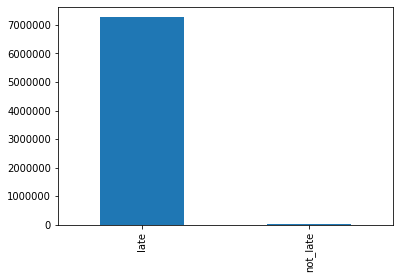

In [14]:
df_toTrain.late_flight.value_counts().plot(kind='bar')

In [15]:
df_toTrain.late_flight.value_counts()

late        7263230
not_late      31419
Name: late_flight, dtype: int64

**NOTE** Looks like a pretty imbalance distribution of target variable.  Will probably need to use SMOTE and create synthetic data for the minority class.

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

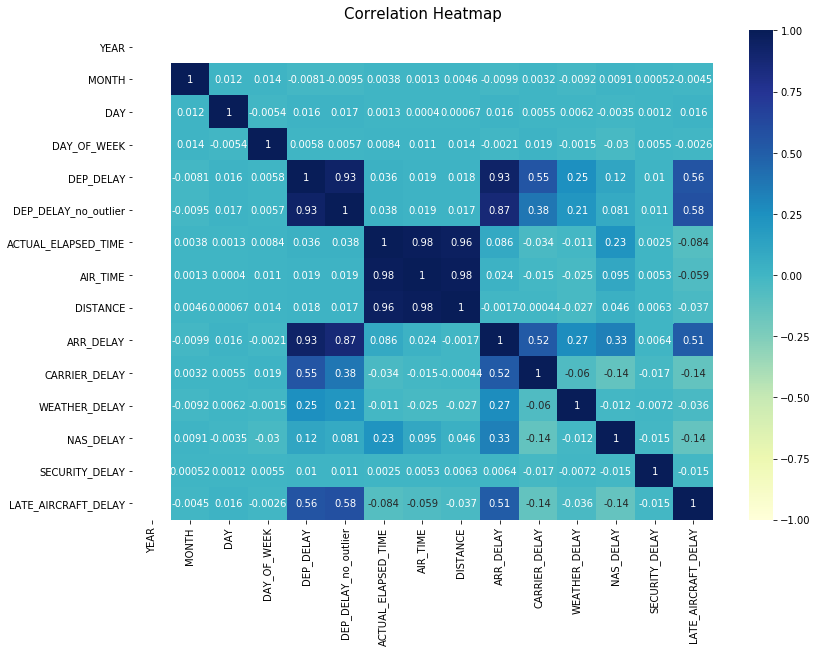

In [16]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_toTrain.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

**NOTE** Looks like high correlation between:
  - `DEP_DELAY_no_outlier` :: `ARR_DELAY`, which could makes logical sense because if you are late departing, then you are likely to be late arriving
  - `ACTUAL_ELAPSED_TIME` :: `DISTANCE` :: `AIR_TIME`, which make sense as each 3-variables are referencing same part of flight

# 3.) Train Model

In [17]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## a. Get the Data

In [18]:
data = df_toTrain.sample(frac=0.01, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (72946, 22)
Unseen Data For Predictions: (7221703, 22)


## b. Setting Up Environment in PyCaret

In [19]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR', 'MONTH','DAY','DAY_OF_WEEK'],
            ignore_features = ['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', 'ARR_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,156
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(72946, 22)"
5,Missing Values,True
6,Numeric Features,11
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


## c. Comparing all models

In [20]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

best_model = compare_models(cross_validation=False)
# best_model = compare_modelfold=old=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9955,0.9119,0.0000,0.0000,0.0000,-0.0001,-0.0005,13.6400
et,Extra Trees Classifier,0.9954,0.7620,0.0000,0.0000,0.0000,-0.0004,-0.0009,19.0600
lightgbm,Light Gradient Boosting Machine,0.9941,0.9674,0.0000,0.0000,0.0000,-0.0023,-0.0026,3.4200
dt,Decision Tree Classifier,0.9923,0.5497,0.1031,0.1087,0.1058,0.1019,0.1020,22.6600
qda,Quadratic Discriminant Analysis,0.9806,0.6054,0.2268,0.0591,0.0938,0.0874,0.1083,3.4800
knn,K Neighbors Classifier,0.9618,0.6035,0.1753,0.0220,0.0391,0.0315,0.0506,12.8900
ada,Ada Boost Classifier,0.9491,0.9694,0.7320,0.0613,0.1131,0.1058,0.2024,14.7400
nb,Naive Bayes,0.9449,0.8286,0.7113,0.0553,0.1027,0.0952,0.1884,0.8500
gbc,Gradient Boosting Classifier,0.9406,0.9665,0.8041,0.0574,0.1072,0.0998,0.2052,65.7800
lr,Logistic Regression,0.8860,0.7789,0.4124,0.0161,0.0311,0.0227,0.0630,15.6000


# 4.) Create Model(s)

## a. Random Forest Classifier

In [21]:
rf = create_model('rf')
# rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
# print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9953,0.8569,0.0000,0.0000,0.0000,-0.0003,-0.0008
1,0.9953,0.8571,0.0000,0.0000,0.0000,-0.0002,-0.0006
Mean,0.9953,0.8570,0.0000,0.0000,0.0000,-0.0002,-0.0007
SD,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001


## b. Ada Boost Classifier

In [22]:
ada = create_model('ada')
# ada = create_model('ada', cross_validation=False)

# trained model object is stored as `ada`
# print(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9655,0.9666,0.5043,0.0669,0.1181,0.1109,0.1745
1,0.9559,0.9652,0.6525,0.0663,0.1203,0.1129,0.1985
Mean,0.9607,0.9659,0.5784,0.0666,0.1192,0.1119,0.1865
SD,0.0048,0.0007,0.0741,0.0003,0.0011,0.0010,0.0120


## c. Light Gradient Boosting Machine

In [23]:
lightgbm = create_model('lightgbm')
# lightgbm = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
# print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9940,0.9641,0.0085,0.0256,0.0128,0.0106,0.0122
1,0.9941,0.9633,0.0000,0.0000,0.0000,-0.0020,-0.0025
Mean,0.9940,0.9637,0.0043,0.0128,0.0064,0.0043,0.0049
SD,0.0001,0.0004,0.0043,0.0128,0.0064,0.0063,0.0073


# 5.) Tune Model(s)

## b. Ada Boost Classifier

In [33]:
tuned_ada = tune_model(ada, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_ada`
# print(tuned_ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9537,0.9673,0.6838,0.0653,0.1192,0.1118,0.2018
1,0.9500,0.9671,0.7203,0.0640,0.1175,0.1099,0.2050
Mean,0.9518,0.9672,0.7020,0.0646,0.1184,0.1109,0.2034
SD,0.0019,0.0001,0.0183,0.0007,0.0009,0.0009,0.0016


# 6.) Models Performance

## b. Ada Boost Classifier

### i. Confusion Matrix

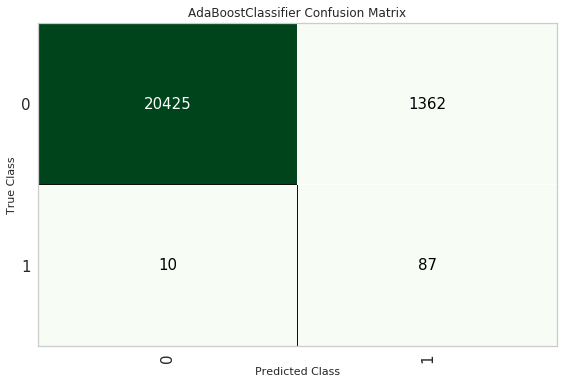

In [34]:
plot_model(tuned_ada, plot = 'confusion_matrix')

### ii. Features Importance

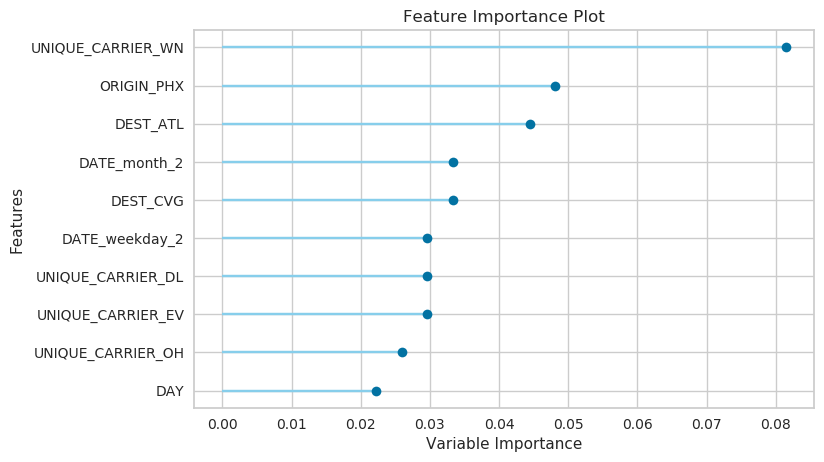

In [35]:
plot_model(tuned_ada, plot='feature')

Features that has greatest explanatory power are:

* `DISTANCE`
* `DAY` of the month
* (closely by) `MONTH`

### iii. Intrepret Model's with SHAP

ref. 

* https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/
* https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/?utm_source=blog&utm_medium=pycaret-machine-learning-model-seconds

In [36]:
!apt-get update && apt-get install -y build-essential -q
!python -m pip install -q shap

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Hit:2 http://deb.debian.org/debian buster InRelease         
Hit:3 http://deb.debian.org/debian buster-updates InRelease 
Fetched 65.4 kB in 0s (208 kB/s)
Reading package lists... Done
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [37]:
interpret_model(tuned_ada, plot='summary')

TypeError: This function only supports tree based models for binary classification: lightgbm, et, rf, dt.

In [38]:
interpret_model(tuned_ada, plot='correlation')

TypeError: This function only supports tree based models for binary classification: lightgbm, et, rf, dt.

# 8.) Predict of Test Data Sample

## a. Ada Boost Classifier

In [39]:
predict_model(tuned_ada)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.9373,0.9673,0.8969,0.0600,0.1125,0.1051,0.2229


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,...,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_1,DATE_is_month_start_1,late_flight,Label,Score
0,1.312284,1.054281,1.516228,1.735268,-0.494496,0.373444,-1.690478,-2.291831,-1.688602,1.039598,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,late,late,0.5901
1,-1.615367,-0.879898,-1.494599,-0.683318,0.507538,0.262685,0.448728,0.224113,0.542092,0.235038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,late,late,0.6169
2,-1.615367,-0.538024,0.042792,-0.084434,0.290964,0.262685,0.448728,0.224113,0.542092,0.235038,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,late,late,0.5545
3,-0.742595,-0.310219,0.539995,0.018263,-1.937314,0.262685,0.448728,0.224113,0.542092,0.235038,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,late,late,0.5610
4,-1.033893,-0.424109,-1.494599,-0.426100,0.004189,0.262685,0.448728,0.224113,0.542092,0.235038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,late,late,0.5889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21879,-1.033893,0.940699,1.030560,1.445624,-0.852383,1.367430,-1.690478,-2.291831,-1.688602,-2.101039,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,late,late,0.5990
21880,-0.158529,0.145049,1.516228,0.376984,-0.739655,0.262685,0.448728,0.224113,0.542092,0.235038,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,late,late,0.5568
21881,0.134470,-0.196356,1.030560,1.843122,-0.937419,-1.534880,-1.690478,-2.291831,-1.688602,2.027989,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,late,late,0.6048
21882,1.312284,1.394928,-0.463156,-0.192630,-1.229765,0.262685,0.448728,0.224113,0.542092,0.235038,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,late,not_late,0.5000


# 9.) Deploy Model (finalized)

## a. Ada Boost Classifier

In [40]:
final_ada = finalize_model(tuned_ada)

#Final model's parameters for deployment
print(final_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.15,
                   n_estimators=270, random_state=156)


**Caution**: Once the model is finalized using `finalize_model()`, the entire dataset including the test/hold-out set is used for training. As a result, if the model is used for predictions on the hold-out set after `finalize_model()` is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

In [ ]:
predict_model(final_ada)

# 10.) Predict on Unseen Dataset

In [ ]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions

In [ ]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'], metric=KPI)

# 11.) Persist Model

In [ ]:
today = datetime.datetime.now()
today_datetime = today.strftime("%d-%m-%Y %H:%M:%S")
pkl_filename = 'Final_model___' + 'ada' + '___for_all_airlines_' + today_datetime

save_model(final_lightgbm, pkl_filename)